In [1]:
import sys
sys.path.append('../RecSysRep/')

In [2]:
import Basics.Load as ld
import scipy.sparse as sps

URM_all, ICM1, ICM2, ICM3, ICM4 = ld.getCOOs()
ICML = ld.getICMlength('5km')
ICM_weighted = ld.getICMselected('7')
ICM_all = sps.hstack([ICM1, ICM3, ICML])
# URM_train, URM_val = ld.getSplit(URM_train_val, 5678, 0.8)

In [3]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=1999)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions


In [39]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'IALS_Hyb' : {"num_factors": 28, "epochs": 10, "confidence_scaling": "linear", "alpha": 0.43657990940994623, "epsilon": 0.35472063248578317, "reg": 0.0001698292271931609, "mw": 0.06122362507952762},
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {'num_factors': 34, 'epochs': 599, 'confidence_scaling': 'linear', 'alpha': 0.003519435539271083, 'epsilon': 0.09222402080721787, 'reg': 2.4127708108457617e-05},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_7': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_3': {'shrink': 2211, 'topK': 188, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_9': {'shrink': 3568, 'topK': 986, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_all': {"shrink": 5212, "topK": 923, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_channel': {"shrink": 2000, "topK": 382, "feature_weighting": "TF-IDF", "normalize": False},
                            'UserKNN' : {'topK': 448, 'similarity': 'cosine', 'shrink': 756, 'normalize': True, 'feature_weighting': 'TF-IDF', 'URM_bias': True},
                         }


In [5]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [6]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender_Hybrid

In [7]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal
from Recommenders.KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
from Recommenders.HybridScores.DifferentStructure import TwoDifferentModelRecommender

In [8]:
recommender1 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
recommender2 = UserKNNCFRecommender(URM_train)

model_init(recommender1, 'SLIM_pure', models_to_combine_best['SLIMER'])
model_init(recommender2, 'UserKNN', models_to_combine_best['UserKNN'])

../models_temp/Similarity_Hybrid/SLIM_pure.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_pure'
SLIMElasticNetRecommender: Loading complete
../models_temp/Similarity_Hybrid/UserKNN.zip
Model found!
UserKNNCFRecommender: Loading model from file '../models_temp/Similarity_Hybrid/UserKNN'
UserKNNCFRecommender: Loading complete


In [9]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])

In [10]:
rank_models(evaluator_validation, [recommender1, recommender2])

EvaluatorHoldout: Processed 13646 (100.0%) in 15.61 sec. Users per second: 874
SLIMElasticNetRecommender 0.24746682846767187
EvaluatorHoldout: Processed 13646 (100.0%) in 12.33 sec. Users per second: 1106
UserKNNCFRecommender 0.2311445967072166


In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import numpy as np

def test_percentage(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = TwoDifferentModelRecommender(URM_train, recommender_a, recommender_b)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(None, alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

EvaluatorHoldout: Processed 13646 (100.0%) in 24.79 sec. Users per second: 550
0.99392 : 0.248314373186863
EvaluatorHoldout: Processed 13646 (100.0%) in 25.56 sec. Users per second: 534
0.9939205263157895 : 0.2483070450320924
EvaluatorHoldout: Processed 13646 (100.0%) in 26.18 sec. Users per second: 521
0.9939210526315789 : 0.2483070450320924
EvaluatorHoldout: Processed 13646 (100.0%) in 25.11 sec. Users per second: 544
0.9939215789473684 : 0.24830614936873152
EvaluatorHoldout: Processed 13646 (100.0%) in 25.23 sec. Users per second: 541
0.9939221052631579 : 0.24830370665047463
EvaluatorHoldout: Processed 13646 (100.0%) in 24.82 sec. Users per second: 550
0.9939226315789473 : 0.24830370665047463
EvaluatorHoldout: Processed 13646 (100.0%) in 24.51 sec. Users per second: 557
0.9939231578947368 : 0.2483045354298832
EvaluatorHoldout: Processed 13646 (100.0%) in 24.58 sec. Users per second: 555
0.9939236842105263 : 0.24830482041367988
EvaluatorHoldout: Processed 13646 (100.0%) in 25.18 sec.

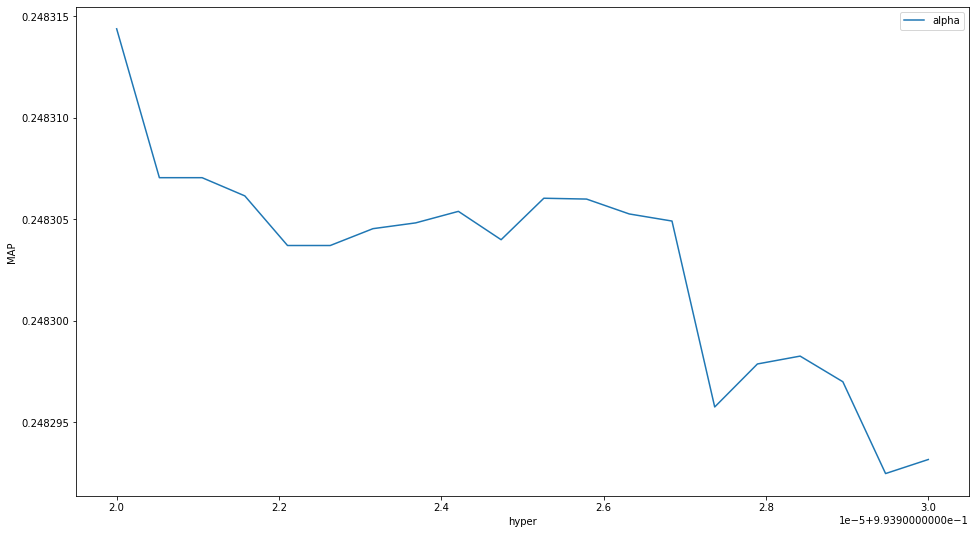

In [19]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.99392, 0.99393, 20)
_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

In [23]:
recommender2 = IALSRecommender(URM_train)

model_init(recommender2, 'IALSn', models_to_combine_best['IALS'])

../models_temp/Similarity_Hybrid/IALSn.zip
Model does not exists, creating...
IALSRecommender: Epoch 1 of 599. Elapsed time 5.28 sec
IALSRecommender: Epoch 2 of 599. Elapsed time 10.54 sec
IALSRecommender: Epoch 3 of 599. Elapsed time 15.79 sec
IALSRecommender: Epoch 4 of 599. Elapsed time 21.44 sec
IALSRecommender: Epoch 5 of 599. Elapsed time 27.78 sec
IALSRecommender: Epoch 6 of 599. Elapsed time 33.51 sec
IALSRecommender: Epoch 7 of 599. Elapsed time 39.18 sec
IALSRecommender: Epoch 8 of 599. Elapsed time 44.96 sec
IALSRecommender: Epoch 9 of 599. Elapsed time 50.69 sec
IALSRecommender: Epoch 10 of 599. Elapsed time 56.22 sec
IALSRecommender: Epoch 11 of 599. Elapsed time 1.03 min
IALSRecommender: Epoch 12 of 599. Elapsed time 1.13 min
IALSRecommender: Epoch 13 of 599. Elapsed time 1.22 min
IALSRecommender: Epoch 14 of 599. Elapsed time 1.31 min
IALSRecommender: Epoch 15 of 599. Elapsed time 1.41 min
IALSRecommender: Epoch 16 of 599. Elapsed time 1.50 min
IALSRecommender: Epoch 17 

IALSRecommender: Epoch 144 of 599. Elapsed time 31.36 min
IALSRecommender: Epoch 145 of 599. Elapsed time 31.62 min
IALSRecommender: Epoch 146 of 599. Elapsed time 31.72 min
IALSRecommender: Epoch 147 of 599. Elapsed time 31.98 min
IALSRecommender: Epoch 148 of 599. Elapsed time 32.08 min
IALSRecommender: Epoch 149 of 599. Elapsed time 32.34 min
IALSRecommender: Epoch 150 of 599. Elapsed time 32.46 min
IALSRecommender: Epoch 151 of 599. Elapsed time 32.72 min
IALSRecommender: Epoch 152 of 599. Elapsed time 32.82 min
IALSRecommender: Epoch 153 of 599. Elapsed time 33.08 min
IALSRecommender: Epoch 154 of 599. Elapsed time 33.19 min
IALSRecommender: Epoch 155 of 599. Elapsed time 33.46 min
IALSRecommender: Epoch 156 of 599. Elapsed time 33.58 min
IALSRecommender: Epoch 157 of 599. Elapsed time 33.82 min
IALSRecommender: Epoch 158 of 599. Elapsed time 33.94 min
IALSRecommender: Epoch 159 of 599. Elapsed time 34.19 min
IALSRecommender: Epoch 160 of 599. Elapsed time 34.32 min
IALSRecommende

IALSRecommender: Epoch 286 of 599. Elapsed time 56.19 min
IALSRecommender: Epoch 287 of 599. Elapsed time 56.36 min
IALSRecommender: Epoch 288 of 599. Elapsed time 56.53 min
IALSRecommender: Epoch 289 of 599. Elapsed time 56.70 min
IALSRecommender: Epoch 290 of 599. Elapsed time 56.87 min
IALSRecommender: Epoch 291 of 599. Elapsed time 57.04 min
IALSRecommender: Epoch 292 of 599. Elapsed time 57.21 min
IALSRecommender: Epoch 293 of 599. Elapsed time 57.37 min
IALSRecommender: Epoch 294 of 599. Elapsed time 57.54 min
IALSRecommender: Epoch 295 of 599. Elapsed time 57.71 min
IALSRecommender: Epoch 296 of 599. Elapsed time 57.89 min
IALSRecommender: Epoch 297 of 599. Elapsed time 58.05 min
IALSRecommender: Epoch 298 of 599. Elapsed time 58.23 min
IALSRecommender: Epoch 299 of 599. Elapsed time 58.39 min
IALSRecommender: Epoch 300 of 599. Elapsed time 58.56 min
IALSRecommender: Epoch 301 of 599. Elapsed time 58.72 min
IALSRecommender: Epoch 302 of 599. Elapsed time 58.81 min
IALSRecommende

IALSRecommender: Epoch 428 of 599. Elapsed time 1.35 hour
IALSRecommender: Epoch 429 of 599. Elapsed time 1.35 hour
IALSRecommender: Epoch 430 of 599. Elapsed time 1.35 hour
IALSRecommender: Epoch 431 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 432 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 433 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 434 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 435 of 599. Elapsed time 1.37 hour
IALSRecommender: Epoch 436 of 599. Elapsed time 1.37 hour
IALSRecommender: Epoch 437 of 599. Elapsed time 1.37 hour
IALSRecommender: Epoch 438 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 439 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 440 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 441 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 442 of 599. Elapsed time 1.39 hour
IALSRecommender: Epoch 443 of 599. Elapsed time 1.39 hour
IALSRecommender: Epoch 444 of 599. Elapsed time 1.39 hour
IALSRecommende

IALSRecommender: Epoch 570 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 571 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 572 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 573 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 574 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 575 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 576 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 577 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 578 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 579 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 580 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 581 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 582 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 583 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 584 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 585 of 599. Elapsed time 1.75 hour
IALSRecommender: Epoch 586 of 599. Elapsed time 1.75 hour
IALSRecommende

In [25]:

models_to_combine_best = {
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {'num_factors': 34, 'epochs': 599, 'confidence_scaling': 'linear', 'alpha': 0.003519435539271083, 'epsilon': 0.09222402080721787, 'reg': 2.4127708108457617e-05},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_7': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_3': {'shrink': 2211, 'topK': 188, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_9': {'shrink': 3568, 'topK': 986, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_all': {"shrink": 5212, "topK": 923, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_channel': {"shrink": 2000, "topK": 382, "feature_weighting": "TF-IDF", "normalize": False},
                            'UserKNN' : {'topK': 448, 'similarity': 'cosine', 'shrink': 756, 'normalize': True, 'feature_weighting': 'TF-IDF', 'URM_bias': True},
                         }

In [26]:
ICM_weighted_7 = ld.getICMselected('7')

recommender1 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_all)
recommender2 = ItemKNNCBFRecommender(URM_all, ICM_weighted_7)
recommender3 = SLIM_BPR_Cython(URM_all)
recommender4 = IALSRecommender(URM_all)

model_init(recommender1, 'SLIM_pure_all', models_to_combine_best['SLIMER'])
model_init(recommender2, 'KNN_all', models_to_combine_best['icm_7'])
model_init(recommender3, 'SLIM_BPR_all', models_to_combine_best['SLIMBPR'])
model_init(recommender4, 'IALS_ALL', models_to_combine_best['IALS'])

ItemKNNCBFRecommender: ICM Detected 22 ( 0.1%) items with no features.
../models_temp/Similarity_Hybrid/SLIM_pure_all.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_pure_all'
SLIMElasticNetRecommender: Loading complete
../models_temp/Similarity_Hybrid/KNN_all.zip
Model does not exists, creating...
Similarity column 18059 (100.0%), 5254.68 column/sec. Elapsed time 3.44 sec
ItemKNNCBFRecommender: Saving model in file '../models_temp/Similarity_Hybrid/KNN_all'
ItemKNNCBFRecommender: Saving complete
../models_temp/Similarity_Hybrid/SLIM_BPR_all.zip
Model does not exists, creating...
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 13650 (100.0%) in 0.70 sec. BPR loss is 1.85E+00. Sample per second: 19558
SLIM_BPR_Recommender: Epoch 1 of 440. Elapsed tim

SLIM_BPR_Recommender: Epoch 51 of 440. Elapsed time 29.88 sec
Processed 13650 (100.0%) in 0.62 sec. BPR loss is 3.01E+01. Sample per second: 22172
SLIM_BPR_Recommender: Epoch 52 of 440. Elapsed time 30.47 sec
Processed 13650 (100.0%) in 1.19 sec. BPR loss is 3.07E+01. Sample per second: 11511
SLIM_BPR_Recommender: Epoch 53 of 440. Elapsed time 31.04 sec
Processed 13650 (100.0%) in 0.78 sec. BPR loss is 3.07E+01. Sample per second: 17594
SLIM_BPR_Recommender: Epoch 54 of 440. Elapsed time 31.63 sec
Processed 13650 (100.0%) in 1.35 sec. BPR loss is 3.05E+01. Sample per second: 10133
SLIM_BPR_Recommender: Epoch 55 of 440. Elapsed time 32.20 sec
Processed 13650 (100.0%) in 0.93 sec. BPR loss is 3.08E+01. Sample per second: 14616
SLIM_BPR_Recommender: Epoch 56 of 440. Elapsed time 32.79 sec
Processed 13650 (100.0%) in 1.52 sec. BPR loss is 3.12E+01. Sample per second: 8966
SLIM_BPR_Recommender: Epoch 57 of 440. Elapsed time 33.38 sec
Processed 13650 (100.0%) in 1.10 sec. BPR loss is 3.19E+0

SLIM_BPR_Recommender: Epoch 107 of 440. Elapsed time 1.04 min
Processed 13650 (100.0%) in 1.52 sec. BPR loss is 3.70E+01. Sample per second: 9009
SLIM_BPR_Recommender: Epoch 108 of 440. Elapsed time 1.06 min
Processed 13650 (100.0%) in 1.17 sec. BPR loss is 3.65E+01. Sample per second: 11686
SLIM_BPR_Recommender: Epoch 109 of 440. Elapsed time 1.07 min
Processed 13650 (100.0%) in 0.79 sec. BPR loss is 3.64E+01. Sample per second: 17215
SLIM_BPR_Recommender: Epoch 110 of 440. Elapsed time 1.08 min
Processed 13650 (100.0%) in 1.36 sec. BPR loss is 3.72E+01. Sample per second: 10046
SLIM_BPR_Recommender: Epoch 111 of 440. Elapsed time 1.09 min
Processed 13650 (100.0%) in 0.92 sec. BPR loss is 3.62E+01. Sample per second: 14796
SLIM_BPR_Recommender: Epoch 112 of 440. Elapsed time 1.10 min
Processed 13650 (100.0%) in 1.49 sec. BPR loss is 3.70E+01. Sample per second: 9144
SLIM_BPR_Recommender: Epoch 113 of 440. Elapsed time 1.11 min
Processed 13650 (100.0%) in 1.09 sec. BPR loss is 3.81E+01

SLIM_BPR_Recommender: Epoch 163 of 440. Elapsed time 1.58 min
Processed 13650 (100.0%) in 1.41 sec. BPR loss is 4.08E+01. Sample per second: 9669
SLIM_BPR_Recommender: Epoch 164 of 440. Elapsed time 1.59 min
Processed 13650 (100.0%) in 1.02 sec. BPR loss is 3.85E+01. Sample per second: 13407
SLIM_BPR_Recommender: Epoch 165 of 440. Elapsed time 1.60 min
Processed 13650 (100.0%) in 0.72 sec. BPR loss is 3.96E+01. Sample per second: 18840
SLIM_BPR_Recommender: Epoch 166 of 440. Elapsed time 1.61 min
Processed 13650 (100.0%) in 1.39 sec. BPR loss is 3.94E+01. Sample per second: 9804
SLIM_BPR_Recommender: Epoch 167 of 440. Elapsed time 1.62 min
Processed 13650 (100.0%) in 1.08 sec. BPR loss is 3.91E+01. Sample per second: 12584
SLIM_BPR_Recommender: Epoch 168 of 440. Elapsed time 1.63 min
Processed 13650 (100.0%) in 0.67 sec. BPR loss is 4.00E+01. Sample per second: 20224
SLIM_BPR_Recommender: Epoch 169 of 440. Elapsed time 1.64 min
Processed 13650 (100.0%) in 1.23 sec. BPR loss is 3.84E+01

SLIM_BPR_Recommender: Epoch 219 of 440. Elapsed time 2.12 min
Processed 13650 (100.0%) in 0.87 sec. BPR loss is 4.04E+01. Sample per second: 15610
SLIM_BPR_Recommender: Epoch 220 of 440. Elapsed time 2.13 min
Processed 13650 (100.0%) in 1.46 sec. BPR loss is 4.11E+01. Sample per second: 9364
SLIM_BPR_Recommender: Epoch 221 of 440. Elapsed time 2.14 min
Processed 13650 (100.0%) in 1.03 sec. BPR loss is 4.05E+01. Sample per second: 13254
SLIM_BPR_Recommender: Epoch 222 of 440. Elapsed time 2.15 min
Processed 13650 (100.0%) in 0.59 sec. BPR loss is 4.01E+01. Sample per second: 23032
SLIM_BPR_Recommender: Epoch 223 of 440. Elapsed time 2.16 min
Processed 13650 (100.0%) in 1.18 sec. BPR loss is 3.96E+01. Sample per second: 11596
SLIM_BPR_Recommender: Epoch 224 of 440. Elapsed time 2.17 min
Processed 13650 (100.0%) in 0.75 sec. BPR loss is 4.10E+01. Sample per second: 18146
SLIM_BPR_Recommender: Epoch 225 of 440. Elapsed time 2.18 min
Processed 13650 (100.0%) in 1.30 sec. BPR loss is 4.09E+0

SLIM_BPR_Recommender: Epoch 275 of 440. Elapsed time 2.66 min
Processed 13650 (100.0%) in 1.41 sec. BPR loss is 4.42E+01. Sample per second: 9692
SLIM_BPR_Recommender: Epoch 276 of 440. Elapsed time 2.67 min
Processed 13650 (100.0%) in 0.93 sec. BPR loss is 4.21E+01. Sample per second: 14632
SLIM_BPR_Recommender: Epoch 277 of 440. Elapsed time 2.68 min
Processed 13650 (100.0%) in 1.46 sec. BPR loss is 4.36E+01. Sample per second: 9368
SLIM_BPR_Recommender: Epoch 278 of 440. Elapsed time 2.69 min
Processed 13650 (100.0%) in 0.98 sec. BPR loss is 4.32E+01. Sample per second: 13946
SLIM_BPR_Recommender: Epoch 279 of 440. Elapsed time 2.70 min
Processed 13650 (100.0%) in 1.50 sec. BPR loss is 4.19E+01. Sample per second: 9097
SLIM_BPR_Recommender: Epoch 280 of 440. Elapsed time 2.71 min
Processed 13650 (100.0%) in 1.02 sec. BPR loss is 4.14E+01. Sample per second: 13326
SLIM_BPR_Recommender: Epoch 281 of 440. Elapsed time 2.71 min
Processed 13650 (100.0%) in 0.55 sec. BPR loss is 4.24E+01.

SLIM_BPR_Recommender: Epoch 331 of 440. Elapsed time 3.15 min
Processed 13650 (100.0%) in 0.80 sec. BPR loss is 4.39E+01. Sample per second: 17081
SLIM_BPR_Recommender: Epoch 332 of 440. Elapsed time 3.16 min
Processed 13650 (100.0%) in 1.32 sec. BPR loss is 4.33E+01. Sample per second: 10329
SLIM_BPR_Recommender: Epoch 333 of 440. Elapsed time 3.17 min
Processed 13650 (100.0%) in 0.85 sec. BPR loss is 4.31E+01. Sample per second: 16144
SLIM_BPR_Recommender: Epoch 334 of 440. Elapsed time 3.18 min
Processed 13650 (100.0%) in 1.37 sec. BPR loss is 4.31E+01. Sample per second: 9995
SLIM_BPR_Recommender: Epoch 335 of 440. Elapsed time 3.19 min
Processed 13650 (100.0%) in 0.89 sec. BPR loss is 4.31E+01. Sample per second: 15292
SLIM_BPR_Recommender: Epoch 336 of 440. Elapsed time 3.20 min
Processed 13650 (100.0%) in 1.42 sec. BPR loss is 4.42E+01. Sample per second: 9620
SLIM_BPR_Recommender: Epoch 337 of 440. Elapsed time 3.20 min
Processed 13650 (100.0%) in 0.94 sec. BPR loss is 4.34E+01

SLIM_BPR_Recommender: Epoch 387 of 440. Elapsed time 3.64 min
Processed 13650 (100.0%) in 1.28 sec. BPR loss is 4.41E+01. Sample per second: 10683
SLIM_BPR_Recommender: Epoch 388 of 440. Elapsed time 3.65 min
Processed 13650 (100.0%) in 0.80 sec. BPR loss is 4.47E+01. Sample per second: 16969
SLIM_BPR_Recommender: Epoch 389 of 440. Elapsed time 3.66 min
Processed 13650 (100.0%) in 1.33 sec. BPR loss is 4.41E+01. Sample per second: 10250
SLIM_BPR_Recommender: Epoch 390 of 440. Elapsed time 3.67 min
Processed 13650 (100.0%) in 0.86 sec. BPR loss is 4.47E+01. Sample per second: 15912
SLIM_BPR_Recommender: Epoch 391 of 440. Elapsed time 3.68 min
Processed 13650 (100.0%) in 1.38 sec. BPR loss is 4.52E+01. Sample per second: 9873
SLIM_BPR_Recommender: Epoch 392 of 440. Elapsed time 3.69 min
Processed 13650 (100.0%) in 0.92 sec. BPR loss is 4.41E+01. Sample per second: 14832
SLIM_BPR_Recommender: Epoch 393 of 440. Elapsed time 3.70 min
Processed 13650 (100.0%) in 1.45 sec. BPR loss is 4.47E+0

IALSRecommender: Epoch 2 of 599. Elapsed time 9.89 sec
IALSRecommender: Epoch 3 of 599. Elapsed time 14.70 sec
IALSRecommender: Epoch 4 of 599. Elapsed time 19.54 sec
IALSRecommender: Epoch 5 of 599. Elapsed time 24.39 sec
IALSRecommender: Epoch 6 of 599. Elapsed time 29.19 sec
IALSRecommender: Epoch 7 of 599. Elapsed time 34.10 sec
IALSRecommender: Epoch 8 of 599. Elapsed time 38.96 sec
IALSRecommender: Epoch 9 of 599. Elapsed time 43.77 sec
IALSRecommender: Epoch 10 of 599. Elapsed time 48.48 sec
IALSRecommender: Epoch 11 of 599. Elapsed time 53.18 sec
IALSRecommender: Epoch 12 of 599. Elapsed time 57.88 sec
IALSRecommender: Epoch 13 of 599. Elapsed time 1.04 min
IALSRecommender: Epoch 14 of 599. Elapsed time 1.12 min
IALSRecommender: Epoch 15 of 599. Elapsed time 1.20 min
IALSRecommender: Epoch 16 of 599. Elapsed time 1.28 min
IALSRecommender: Epoch 17 of 599. Elapsed time 1.35 min
IALSRecommender: Epoch 18 of 599. Elapsed time 1.43 min
IALSRecommender: Epoch 19 of 599. Elapsed time

IALSRecommender: Epoch 148 of 599. Elapsed time 11.74 min
IALSRecommender: Epoch 149 of 599. Elapsed time 11.82 min
IALSRecommender: Epoch 150 of 599. Elapsed time 11.90 min
IALSRecommender: Epoch 151 of 599. Elapsed time 11.98 min
IALSRecommender: Epoch 152 of 599. Elapsed time 12.06 min
IALSRecommender: Epoch 153 of 599. Elapsed time 12.14 min
IALSRecommender: Epoch 154 of 599. Elapsed time 12.22 min
IALSRecommender: Epoch 155 of 599. Elapsed time 12.30 min
IALSRecommender: Epoch 156 of 599. Elapsed time 12.37 min
IALSRecommender: Epoch 157 of 599. Elapsed time 12.45 min
IALSRecommender: Epoch 158 of 599. Elapsed time 12.53 min
IALSRecommender: Epoch 159 of 599. Elapsed time 12.61 min
IALSRecommender: Epoch 160 of 599. Elapsed time 12.69 min
IALSRecommender: Epoch 161 of 599. Elapsed time 12.76 min
IALSRecommender: Epoch 162 of 599. Elapsed time 12.84 min
IALSRecommender: Epoch 163 of 599. Elapsed time 12.92 min
IALSRecommender: Epoch 164 of 599. Elapsed time 13.00 min
IALSRecommende

IALSRecommender: Epoch 290 of 599. Elapsed time 23.13 min
IALSRecommender: Epoch 291 of 599. Elapsed time 23.22 min
IALSRecommender: Epoch 292 of 599. Elapsed time 23.30 min
IALSRecommender: Epoch 293 of 599. Elapsed time 23.38 min
IALSRecommender: Epoch 294 of 599. Elapsed time 23.46 min
IALSRecommender: Epoch 295 of 599. Elapsed time 23.55 min
IALSRecommender: Epoch 296 of 599. Elapsed time 23.63 min
IALSRecommender: Epoch 297 of 599. Elapsed time 23.71 min
IALSRecommender: Epoch 298 of 599. Elapsed time 23.79 min
IALSRecommender: Epoch 299 of 599. Elapsed time 23.87 min
IALSRecommender: Epoch 300 of 599. Elapsed time 23.95 min
IALSRecommender: Epoch 301 of 599. Elapsed time 24.03 min
IALSRecommender: Epoch 302 of 599. Elapsed time 24.12 min
IALSRecommender: Epoch 303 of 599. Elapsed time 24.20 min
IALSRecommender: Epoch 304 of 599. Elapsed time 24.28 min
IALSRecommender: Epoch 305 of 599. Elapsed time 24.36 min
IALSRecommender: Epoch 306 of 599. Elapsed time 24.44 min
IALSRecommende

IALSRecommender: Epoch 432 of 599. Elapsed time 34.55 min
IALSRecommender: Epoch 433 of 599. Elapsed time 34.63 min
IALSRecommender: Epoch 434 of 599. Elapsed time 34.71 min
IALSRecommender: Epoch 435 of 599. Elapsed time 34.78 min
IALSRecommender: Epoch 436 of 599. Elapsed time 34.86 min
IALSRecommender: Epoch 437 of 599. Elapsed time 34.94 min
IALSRecommender: Epoch 438 of 599. Elapsed time 35.02 min
IALSRecommender: Epoch 439 of 599. Elapsed time 35.10 min
IALSRecommender: Epoch 440 of 599. Elapsed time 35.18 min
IALSRecommender: Epoch 441 of 599. Elapsed time 35.26 min
IALSRecommender: Epoch 442 of 599. Elapsed time 35.34 min
IALSRecommender: Epoch 443 of 599. Elapsed time 35.42 min
IALSRecommender: Epoch 444 of 599. Elapsed time 35.50 min
IALSRecommender: Epoch 445 of 599. Elapsed time 35.58 min
IALSRecommender: Epoch 446 of 599. Elapsed time 35.66 min
IALSRecommender: Epoch 447 of 599. Elapsed time 35.74 min
IALSRecommender: Epoch 448 of 599. Elapsed time 35.82 min
IALSRecommende

IALSRecommender: Epoch 574 of 599. Elapsed time 45.92 min
IALSRecommender: Epoch 575 of 599. Elapsed time 46.00 min
IALSRecommender: Epoch 576 of 599. Elapsed time 46.08 min
IALSRecommender: Epoch 577 of 599. Elapsed time 46.17 min
IALSRecommender: Epoch 578 of 599. Elapsed time 46.26 min
IALSRecommender: Epoch 579 of 599. Elapsed time 46.34 min
IALSRecommender: Epoch 580 of 599. Elapsed time 46.42 min
IALSRecommender: Epoch 581 of 599. Elapsed time 46.50 min
IALSRecommender: Epoch 582 of 599. Elapsed time 46.58 min
IALSRecommender: Epoch 583 of 599. Elapsed time 46.66 min
IALSRecommender: Epoch 584 of 599. Elapsed time 46.74 min
IALSRecommender: Epoch 585 of 599. Elapsed time 46.82 min
IALSRecommender: Epoch 586 of 599. Elapsed time 46.90 min
IALSRecommender: Epoch 587 of 599. Elapsed time 46.98 min
IALSRecommender: Epoch 588 of 599. Elapsed time 47.06 min
IALSRecommender: Epoch 589 of 599. Elapsed time 47.14 min
IALSRecommender: Epoch 590 of 599. Elapsed time 47.22 min
IALSRecommende

In [36]:
recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_all, recommender1.W_sparse, recommender2.W_sparse)
recommender.fit(0.9210344)

In [37]:
recommender_1 = ItemKNNSimilarityHybridRecommenderNormal(URM_all, recommender.W_sparse, recommender3.W_sparse)
recommender_1.fit(0.98857378)

In [38]:
import pandas as pd
K=10

user_test_path = '../data/data_target_users_test.csv'
user_test_dataframe = pd.read_csv(filepath_or_buffer=user_test_path,
                                sep=",",
                                dtype={0:int})

subm_set = user_test_dataframe.to_numpy().T[0]

subm_res = {"user_id":[], "item_list":[]}

for user_id in subm_set:
    subm_res["user_id"].append(user_id)
    res = recommender_1.recommend(user_id, K)
    res = ' '.join(map(str, res))
    if user_id < 3:
        print(user_id)
        print(res)
    subm_res["item_list"].append(res)


# print(subm_res)

submission = pd.DataFrame.from_dict(subm_res)
# submission

from datetime import datetime
now = datetime.now() # current date and time


submission.to_csv('../subs/submission {:%Y_%m_%d %H_%M_%S}.csv'.format(now), index=False)

0
3899 5433 8465 16359 16365 6061 2243 9130 10586 640
1
3473 940 14400 640 16365 16012 2118 9275 14358 9373
2
6177 1551 17330 17022 16365 15119 2846 14229 5925 2748
